# Recreating the `demo_derangments_basic` model from the [work](https://qtechtheory.org/derangement_circuits/) of Balint Koczor
---

In [1]:
import asset_func as af
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

## The circuit
---

### The observable:

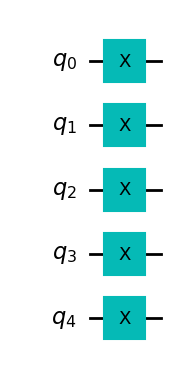

In [2]:
obs = QuantumCircuit(5)
obs.x(range(5))
obs.draw(style="default")

### The full circuit:

/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


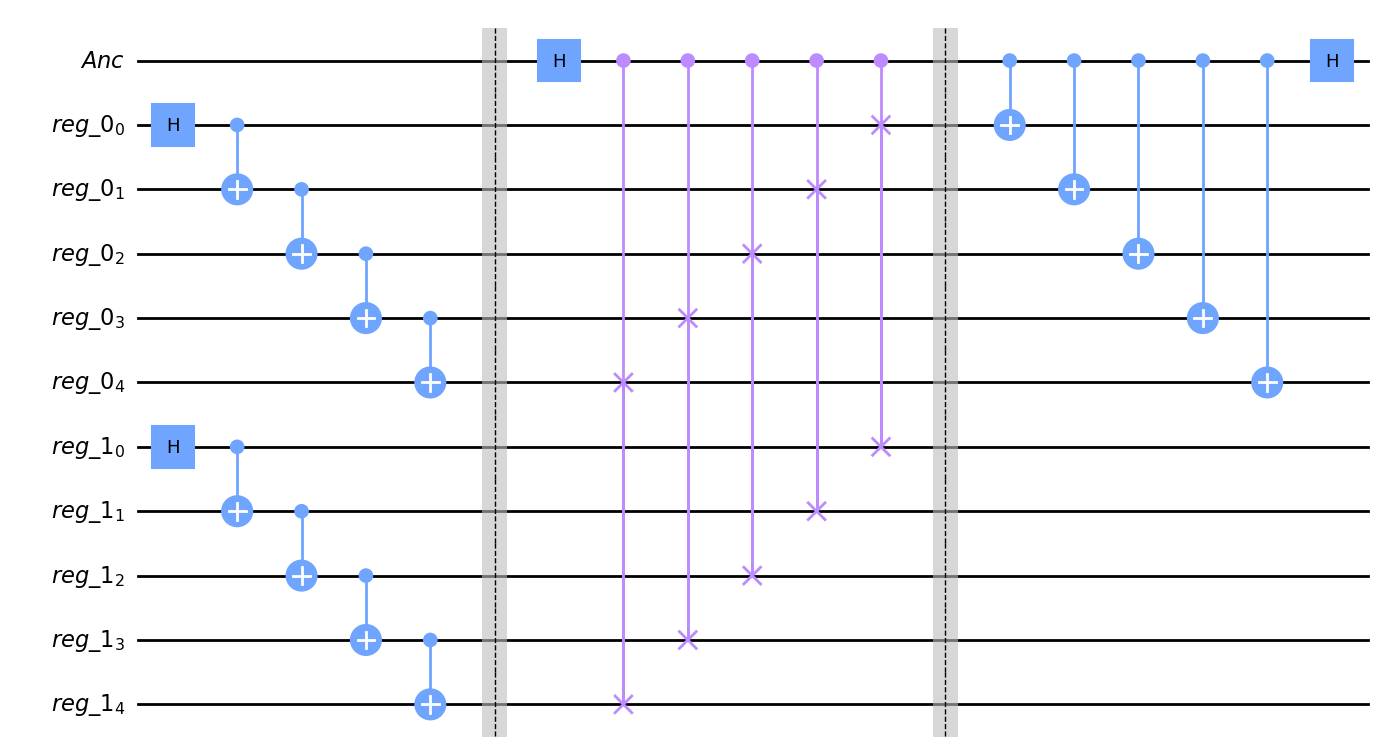

In [3]:
full_qc = af.circ_assembler(numReg = 2, numQ = 5, numAnc = 1, sigma = obs, 
                         basis_gates = ['cx'], der_op = True)

full_qc.draw(style="default")

## Expectation value
---

### Exact expectation value:
The known expectation value of the circuit is $1$. We can also check this using the `circ_tester()` function which returns the expectation value both for the mitigated and unmitigated (circuit without the derangement operator) circuits. 

In [4]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots # we calcualte the expectation value from the density matrix
noise_model = None # we are not applying noise at this point, see later sections

mit, unmit = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs, 
                         basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_model)

print('The mitigated expectation value is: {} and the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: 1.0 and the unmitigated is: 1.0.


### Estimated expectation value, with the noise model from the demo:

In the mathematica demo, a depolarizing error with probability $p = 0.01$ is added to after each $CX$ gate of the $\text{GHZ}$ state. Here we reproduce the same noise model and obtain the expectation value first by performing the exact calculation second by estimating it using $10000$ shots.

In order to only apply the depolarizing error to the $CX$ gates for the $\text{GHZ}$ state and not for the observable, we redifine the $\text{GHZ}$ function by decomposing it into costum $CX$ gates:

1. Creating costum cx gate:

In [5]:
from qiskit.extensions import CXGate

In [6]:
costum_cx_gate = CXGate(label = "costum_cx")

2. redifining `GHZ()`

In [7]:
def GHZ_new(qc):

    registers = qc.qregs[:0:-1]
    numQubits = registers[0].size

    for reg in registers:
        qc.h(reg[0])

        for qubit in range(numQubits-1):
            qc.append(costum_cx_gate, (reg[qubit], reg[qubit+1])) # <-- redifining happens here!

In [8]:
af.GHZ = GHZ_new

Let's have a look at the new circuit:

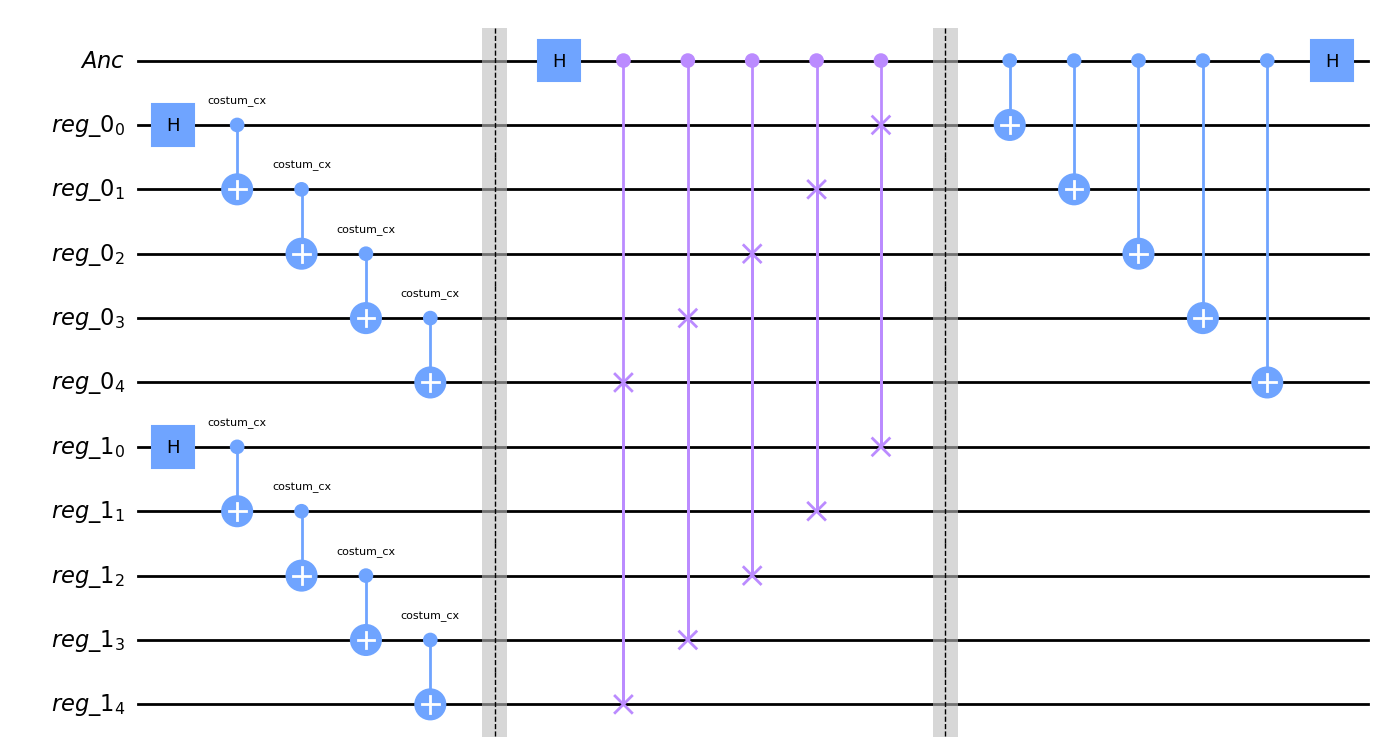

In [9]:
full_qc = af.circ_assembler(numReg = 2, numQ = 5, numAnc = 1, sigma = obs, 
                         basis_gates = ['cx'], der_op = True)

full_qc.draw(style="default", fold = -1) # uncomment to show circuit with costum cx gates

#### Creating the noise model:

In [10]:
error = 0.01 # defining error probability

err_2q = depolarizing_error(error, 2) # 2 qubit error for costum cx gates in the GHZ state

noise_simple = NoiseModel() # create noise model
noise_simple.add_all_qubit_quantum_error(err_2q, costum_cx_gate.label)

noise_simple.add_basis_gates(['h', 'cx', 'cswap', 'costum_cx'])

print(noise_simple)

NoiseModel:
  Basis gates: ['cswap', 'cx', 'h', 'id', 'rz', 'sx']
  Instructions with noise: ['costum_cx']
  All-qubits errors: ['costum_cx']


Finally evaulting the circuit:

1. exact expectation value:

In [11]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots
noise_model = noise_simple # we 
mit, unmit = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs, 
                         basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_model)

print('The mitigated expectation value is: {},\nand the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: 0.9999287706664044,
and the unmitigated is: 0.9802980050000003.


2. estimated expectation value using $100000$ shots:

In [12]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 100000 # we are interested in the exact (algeabraic) expectation value hence no shots # we calcualte the expectation value from the density matrix
noise_model = noise_simple # we are not applying noise at this point, see later sections

mit, unmit = af.circ_tester(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs, 
                         basis_gates = basis_gates, nb_shots = nb_shots, noise_model = noise_model)

print('The mitigated expectation value is: {},\nand the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: 0.9999482781806334,
and the unmitigated is: 0.98088.
